In [21]:
import os, sys, random, re, collections, string
import numpy as np
import torch
import math
import csv
import sklearn.model_selection
import sklearn.metrics
import heapq
import matplotlib
import tqdm
import transformers
import datasets
import sentence_transformers
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoModelForCausalLM, RobertaTokenizer, AutoTokenizer
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from torch.optim import AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
true = np.random.randint(0, 2, (1, 100)).reshape(-1)
pred = np.random.randint(0, 2, (1, 100)).reshape(-1)
# pred = np.full((1, 100), 0).reshape(-1)

In [ ]:
cm = confusion_matrix(true, pred)
cm

In [ ]:
print(f"""acc: {accuracy_score(true, pred):.3f}, f1: {f1_score(true, pred, average="macro"):.3f}
Yes: prec: {precision_score(true, pred, pos_label=1, zero_division=0):.3f}, recall: {recall_score(true, pred, pos_label=1, zero_division=0):.3f}, f1: {f1_score(true, pred, pos_label=1, zero_division=0):.3f}
No: prec: {precision_score(true, pred, pos_label=0, zero_division=0):.3f}, recall: {recall_score(true, pred, pos_label=0, zero_division=0):.3f}, f1: {f1_score(true, pred, pos_label=0, zero_division=0):.3f}
""")

In [ ]:
input = torch.randn(1, 500, 100)
target = torch.randint(0, 500, (1, 100))
F.cross_entropy(input, target)

In [ ]:
m = nn.Sigmoid()
input = torch.randn(3, 2, requires_grad=True)
target = torch.rand(3, 2, requires_grad=False)
output = F.binary_cross_entropy(m(input), target, reduction='none')
output, input, target

In [ ]:
criterion = torch.nn.BCELoss()
outputs = torch.sigmoid(model(inputs))  # shape: [batch_size]
loss = criterion(outputs, targets)


In [ ]:
import torch
import torch.nn as nn

# Dummy input: 3 samples, 1 output neuron (binary classification)
logits = torch.tensor([[0.2], [1.0], [-1.0]], dtype=torch.float32)
targets = torch.tensor([[0.0], [1.0], [0.0]], dtype=torch.float32)  # labels

# Convert logits to probabilities
probs = torch.sigmoid(logits)

# Use BCELoss
bce_loss = nn.BCELoss()
loss = bce_loss(probs, targets)

print(f"BCELoss: {loss.item():.4f}")


In [ ]:
input = torch.randn(1, 500, 100)
target = torch.tensor(torch.randint(0, 500, (1, 100))
# F.cross_entropy(input, target)

In [ ]:

# Parts I and II
boolq_dataset = load_dataset('google/boolq')

boolq_dataset

In [28]:
val_labels = [1 if x["answer"] else 0 for x in boolq_dataset["validation"]]

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, RobertaTokenizer, AutoModelForCausalLM, RobertaForMaskedLM
# tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
# model = GPT2LMHeadModel.from_pretrained('distilgpt2').cuda()
# model = AutoModelForCausalLM.from_pretrained('distilgpt2').cuda()

tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')
model = RobertaForMaskedLM.from_pretrained('distilroberta-base')#.cuda()

In [ ]:
model.lm_head = nn.Sequential(
    nn.Linear(model.lm_head.dense.in_features, 1),
    nn.Sigmoid()
)#.cuda()

In [43]:
model = model.cuda()

In [44]:
input = torch.randint(0, tokenizer.vocab_size, (5, 256)).cuda()

In [52]:
out = model(input)

In [ ]:
out.logits#[:, -1, :]

In [ ]:
out.logits.shape

In [60]:
a = torch.randint(0, 2, (1000, 1))

In [ ]:
a.shape

In [29]:
def boolq2tensor(x, append_answer=False):
    if append_answer:
        return tokenizer.encode(f"{x['passage']}.\n{x['question']}?\n{'yes' if x['answer'] else 'no'}", return_tensors="pt")
    else:
        return tokenizer.encode(f"{x['passage']}.\n{x['question']}?\n", return_tensors="pt")
# List is alright here for the moment since max token length is 1024 and the max in the dataset is 25
val_set = [boolq2tensor(x) for x in boolq_dataset["validation"]]
train_set = [boolq2tensor(x, append_answer=True) for x in boolq_dataset["train"]]
train_set2 = [boolq2tensor(x) for x in boolq_dataset["train"]]

In [16]:
val_len = pd.Series(val_set).apply(lambda x: x.shape[1])
train_len = pd.Series(train_set).apply(lambda x: x.shape[1])

In [ ]:
val_len.hist(bins=100)



In [ ]:
train_len.hist(bins=100)

In [13]:
def tensorlist2padded(tensorlist, length: int, pad_token_id: int, pad_strategy: str):
    assert len(tensorlist) > 0
    assert all(x.ndim == 2 for x in tensorlist)
    assert all(x.shape[0] == 1 for x in tensorlist)
    assert length > 0
    assert pad_token_id is not None
    assert pad_strategy in {"left", "right"}

    for i, x in enumerate(tensorlist):
        if x.shape[1] < length:
            if pad_strategy == "left":
                tensorlist[i] = torch.cat([torch.full((1, length - x.shape[1]), pad_token_id), x], dim=1)
            else:
                tensorlist[i] = torch.cat([x, torch.full((1, length - x.shape[1]), pad_token_id)], dim=1)
        elif x.shape[1] > length:
            if pad_strategy == "left":
                tensorlist[i] = x[:, -length:]
            else:
                tensorlist[i] = x[:, :length]
        else:
            assert x.shape[1] == length

    concat_tensor = torch.cat(tensorlist, dim=0)
    return concat_tensor

# val_tensor = tensorlist2padded(val_set, 200, tokenizer.unk_token_id, "left").cuda()
# train_tensor = tensorlist2padded(train_set, 1024, tokenizer.unk_token_id, "left").cuda()


In [14]:
# train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_tensor, batch_size=16, shuffle=False)


In [ ]:
labels_pred = []
# for x in val_set:
for x in tqdm.tqdm(val_set):
    with torch.no_grad():
        if x.shape[1] > 1024:
            x = x[:, -1024:]
        out = model(x.cuda()).logits
        # labels_pred.extend(out[:, -1, [645, 3763]].argmax(dim=1).cpu().tolist())
        labels_pred.extend(out[:, -1, [3919, 8505]].argmax(dim=1).cpu().tolist())

# tokenizer.decode(out[:, -1, :].argmax(dim=1))

In [21]:
# labels_pred = []
# for x in val_loader:
#     with torch.no_grad():
#         out = model(x.cuda()).logits
#         labels_pred.extend(out[:, -1, [645, 3763]].argmax(dim=1).cpu().tolist())


In [22]:
labels = [1 if x['answer'] else 0 for x in boolq_dataset["validation"]]

In [ ]:
from collections import Counter
Counter(labels_pred), Counter(labels)

In [ ]:
# tokenizer.encode(["no", "yes"]) -> [3919, 8505]
output_stacked = torch.stack(outputs)[:, [645, 3763]]

In [45]:
labels = np.array([1 if x['answer'] else 0 for x in boolq_dataset["validation"]])

In [46]:
label_pred = output_stacked.argmax(dim=1)
label_pred = label_pred.cpu().numpy()

In [ ]:
print(f"""
Overall: acc: {accuracy_score(labels, label_pred):.3f}, f1: {f1_score(labels, label_pred):.3f}
    Yes: prec: {precision_score(labels, label_pred, pos_label=1):.3f}, recall: {recall_score(labels, label_pred, pos_label=1):.3f}, f1: {f1_score(labels, label_pred, pos_label=1):.3f}
     No: prec: {precision_score(labels, label_pred, pos_label=0):.3f}, recall: {recall_score(labels, label_pred, pos_label=0):.3f}, f1: {f1_score(labels, label_pred, pos_label=0):.3f}
""")

In [65]:
model = model.cpu()

In [66]:
torch.cuda.empty_cache()

In [ ]:
tokenizer.SPECIAL_TOKENS_ATTRIBUTES

In [4]:
model = AutoModelForCausalLM.from_pretrained("distilroberta-base", is_decoder=True)
model.lm_head = nn.Sequential(
    nn.Linear(model.lm_head.dense.in_features, 1), nn.Sigmoid()
)
model = model.cuda()

In [ ]:
input = torch.randint(0, 50256, (5, 256)).cuda()
out = model(input)

In [ ]:
out.logits[:, -1, :].shape

In [ ]:
out.keys()

In [67]:
def get_distilroberta_rand():
    model = AutoModelForCausalLM.from_pretrained('distilroberta-base')
    for name, module in model.named_modules():
        # TODO: check if this is correct or this is to be done for all layers
        if "roberta.encoder.layer.4" in name or "roberta.encoder.layer.5" in name:
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight)
                nn.init.normal_(module.bias)
            elif isinstance(module, nn.LayerNorm):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
    return model

In [68]:
def get_distilroberta_kqv():
    model = AutoModelForCausalLM.from_pretrained('distilroberta-base')
    for name, module in model.named_modules():
        if name in {"roberta.encoder.layer.4", "roberta.encoder.layer.5"}:
            w = (module.attention.self.key.weight + module.attention.self.query.weight) / 2
            b = (module.attention.self.key.bias + module.attention.self.query.bias) / 2
            shared_linear_layer = nn.Linear(w.shape[1], w.shape[0])
            with torch.no_grad():
                shared_linear_layer.weight.copy_(w)
                shared_linear_layer.bias.copy_(b)
            module.attention.self.key = shared_linear_layer
            module.attention.self.query = shared_linear_layer
            module.attention.self.value = shared_linear_layer

In [85]:
# Copied from transformers.models.bert.modeling_bert.BertOutput
class RobertaOutputNoRes(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states

class RobertaSelfOutputNoRes(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states


def get_distilroberta_nores():
    model = AutoModelForCausalLM.from_pretrained('distilroberta-base')

    for name, module in model.named_modules():
        if name in {"roberta.encoder.layer.4", "roberta.encoder.layer.5"}:
            nores_self_output = RobertaSelfOutputNoRes(model.config)
            nores_output = RobertaOutputNoRes(model.config)

            nores_self_output.load_state_dict(module.attention.output.state_dict())
            nores_output.load_state_dict(module.output.state_dict())

            module.attention.output = nores_self_output
            module.output = nores_output
    return model

In [22]:
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')

In [ ]:
model3 = get_distilroberta_nores().cuda()

In [88]:
input = torch.randint(0, tokenizer.vocab_size, (5, 256)).cuda()

In [ ]:
model3(input).logits.shape

In [44]:
sst_dataset = load_dataset('stanfordnlp/sst')

Using the latest cached version of the module from /home/vijay/.cache/huggingface/modules/datasets_modules/datasets/stanfordnlp--sst/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff (last modified on Mon Apr 14 17:06:46 2025) since it couldn't be found locally at stanfordnlp/sst, or remotely on the Hugging Face Hub.


In [50]:
sst_dataset["train"]

Dataset({
    features: ['sentence', 'label', 'tokens', 'tree'],
    num_rows: 8544
})

In [53]:
[x['label'] for x in sst_dataset["train"]]


[0.6944400072097778,
 0.833329975605011,
 0.625,
 0.5,
 0.7222200036048889,
 0.833329975605011,
 0.875,
 0.7222200036048889,
 0.833329975605011,
 0.7361099720001221,
 0.9027799963951111,
 0.44444000720977783,
 0.8055599927902222,
 0.44444000720977783,
 0.8194400072097778,
 0.75,
 0.6111099720001221,
 0.44444000720977783,
 0.8194400072097778,
 0.7777799963951111,
 0.8194400072097778,
 0.6388900279998779,
 0.5555599927902222,
 0.875,
 0.5555599927902222,
 0.5138900279998779,
 0.9444400072097778,
 0.7222200036048889,
 0.9305599927902222,
 0.3333300054073334,
 0.8194400072097778,
 0.7777799963951111,
 0.5694400072097778,
 0.7361099720001221,
 0.8611099720001221,
 0.6805599927902222,
 0.7361099720001221,
 0.7222200036048889,
 0.541670024394989,
 0.6805599927902222,
 0.7638900279998779,
 0.833329975605011,
 0.4027799963951111,
 0.6527799963951111,
 0.5277799963951111,
 0.16666999459266663,
 0.7777799963951111,
 0.6111099720001221,
 0.375,
 0.9444400072097778,
 0.75,
 0.8611099720001221,
 0.6

In [47]:
[x['sentence'] for x in sst_dataset["train"]]

["The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",
 "The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .",
 'Singer\\/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece .',
 "You 'd think by now America would have had enough of plucky British eccentrics with hearts of gold .",
 'Yet the act is still charming here .',
 "Whether or not you 're enlightened by any of Derrida 's lectures on `` the other '' and `` the self , '' Derrida is an undeniably fascinating and playful fellow .",
 'Just the labour involved in creating the layered ri

In [33]:
model = GPT2LMHeadModel.from_pretrained('distilgpt2')

In [39]:
from transformers import RobertaModel, RobertaForCausalLM, RobertaForMaskedLM
model = RobertaModel.from_pretrained('distilroberta-base')
# model = RobertaForCausalLM.from_pretrained('distilroberta-base', is_decoder=False)
# model = RobertaForMaskedLM.from_pretrained('distilroberta-base')
# model.pooler.dense = nn.Linear(model.config.hidden_size, 1)
# model.pooler.activation = nn.Identity() #nn.Sigmoid()
# model

In [40]:
input = torch.randint(0, tokenizer.vocab_size, (5, 512))

In [42]:
mask = torch.randint(0, 2, (5, 512))
mask = mask.bool()

In [43]:
model(input, attention_mask=mask).keys()#.pooler_output.shape

odict_keys(['last_hidden_state', 'pooler_output'])

In [64]:
a = [tokenizer.encode(x['sentence']) for x in sst_dataset['train']]
b = [x['label'] for x in sst_dataset['train']]

In [54]:
a = []

In [60]:
b = torch.randn(5, 100)

In [61]:
a.extend(b.cpu().tolist())

In [63]:
np.array(a).shape

(10, 100)

<Axes: >

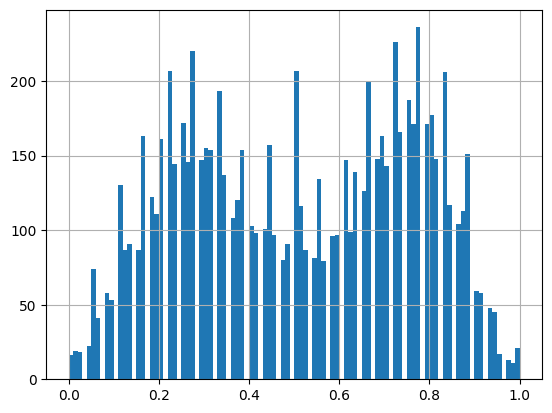

In [67]:
pd.Series(b).hist(bins=100)


<Axes: >

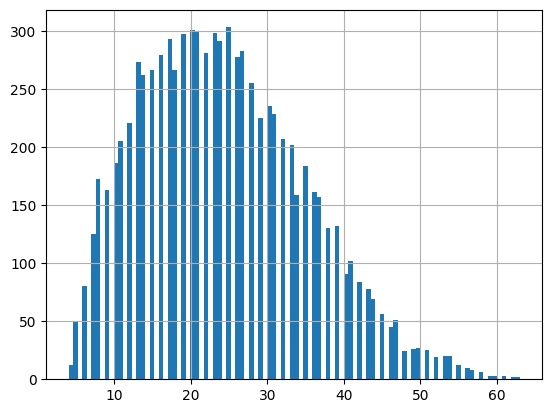

In [65]:
pd.Series([len(x) for x in a]).hist(bins=100)


In [10]:
sst_dataset['train'][0]

{'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",
 'label': 0.6944400072097778,
 'tokens': "The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.",
 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0'}